<a href="https://colab.research.google.com/github/ResistorCat/recsys-project/blob/feat%2FdeepFM/LightFM_Meal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
FLAG_DATASET_DL = True

## 1. Carga de datos y librerías

In [4]:
# Actualizar pip
%pip install --upgrade pip
# Dependencias para graficar y manipular datos
%pip install pandas matplotlib tqdm seaborn ipywidgets ace_tools
# Dependencias para leer archivos Parquet
%pip install pyarrow fastparquet
# Para predicción
%pip install scikit-learn lightfm recommenders torch_geometric


  Using cached lightfm-1.17-cp311-cp311-linux_x86_64.whl
  Using cached recommenders-1.2.1-py3-none-any.whl.metadata (13 kB)
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached category_encoders-2.8.1-py3-none-any.whl.metadata (7.9 kB)
  Using cached cornac-2.3.3-cp311-cp311-manylinux1_x86_64.whl.metadata (51 kB)
  Using cached locust-2.37.11-py3-none-any.whl.metadata (9.4 kB)
  Using cached memory_profiler-0.61.0-py3-none-any.whl.metadata (20 kB)
  Using cached retrying-1.4.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pandera-0.24.0-py3-none-any.whl.metadata (10 kB)
  Using cached powerlaw-1.5-py3-none-any.whl.metadata (9.3 kB)
  Using cached configargparse-1.7.1-py3-none-any.whl.metadata (24 kB)
  Using cached flask_cors-6.0.1-py3-none-any.whl.metadata (5.3 k

In [5]:
# Importar librerías globales

# Manejo de datos y visualización
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import zipfile


# Crear directorios
PATH_DATASETS = "datasets"
PATH_DATASETS_MEALRECPLUS = os.path.join(PATH_DATASETS, "mealrecplus")
os.makedirs(PATH_DATASETS, exist_ok=True)

In [6]:
PATH_MEALRECPLUS_META_DATA = "/content/datasets/mealrecplus/MealRecPlus-main/MealRec+/MealRec+H/meta_data/"
PATH_MEALRECPLUS_HEALTHINESS = "/content/datasets/mealrecplus/MealRecPlus-main/MealRec+/MealRec+H/healthiness/"

In [7]:
if FLAG_DATASET_DL:
  # Descargar "MealRecPlus" de WUT-IDEA
  os.system(f"curl -L -o {PATH_DATASETS_MEALRECPLUS}.zip https://github.com/WUT-IDEA/MealRecPlus/archive/refs/heads/main.zip")
  os.system(f"unzip -o {PATH_DATASETS_MEALRECPLUS}.zip -d {PATH_DATASETS_MEALRECPLUS}")
  # Eliminar el zip
  os.remove(f"{PATH_DATASETS_MEALRECPLUS}.zip")
  # Cita: Ming Li, Lin Li, Xiaohui Tao, and Jimmy Xiangji Huang. 2024. MealRec+: A Meal Recommendation Dataset with Meal-Course Affiliation for Personal- ization and Healthiness. In Proceedings of the 47th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR ’24), July 14–18, 2024, Washington, DC, USA. ACM, New York, NY, USA, 11 pages. https://doi.org/10.1145/3626772.3657857 (https://github.com/WUT-IDEA/MealRecPlus)
  zip_path_course = PATH_MEALRECPLUS_META_DATA+"course.zip"
  zip_path_user_course = PATH_MEALRECPLUS_META_DATA+"user_course.zip"
  extract_path_course = PATH_MEALRECPLUS_META_DATA

  os.makedirs(extract_path_course, exist_ok=True)

  with zipfile.ZipFile(zip_path_course, 'r') as zip_ref:
      zip_ref.extractall(extract_path_course)

  with zipfile.ZipFile(zip_path_user_course, 'r') as zip_ref:
      zip_ref.extractall(extract_path_course)

  print("✅ Archivos descomprimidos en:", extract_path_course)


✅ Archivos descomprimidos en: /content/datasets/mealrecplus/MealRecPlus-main/MealRec+/MealRec+H/meta_data/


## 2. Preprocesamiento de datos

In [8]:
# Cargar interacciones usuario-plato (ratings)
df_user_course = pd.read_csv(
    PATH_MEALRECPLUS_META_DATA+"user_course.csv",
    names=["user_id", "course_id", "rating", "dateLastModified"],
    header=None
)

# Convertir la columna 'rating' a tipo numérico, forzando los errores a NaN
df_user_course['rating'] = pd.to_numeric(df_user_course['rating'], errors='coerce')
df_user_course.dropna(subset=['rating'], inplace=True)

df_course = pd.read_csv(PATH_MEALRECPLUS_META_DATA+"course.csv")

df_user2index = pd.read_csv(PATH_MEALRECPLUS_META_DATA+"user2index.txt", sep="\t", names=["user_id", "user_index"])
df_course2index = pd.read_csv(PATH_MEALRECPLUS_META_DATA+"course2index.txt", sep="\t", names=["course_id", "course_index"])

/tmp/ipython-input-8-1742593322.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_user_course = pd.read_csv(


In [9]:
df_user_course.head()

,user_id,course_id,rating,dateLastModified
1,39,61727,4.0,2001-03-26T07:36:16.653\n
2,39,7612,5.0,2004-08-02T16:48:37.107\n
3,39,12009,4.0,2001-02-28T10:37:25.59\n
4,39,88185,5.0,2009-05-18T14:55:11.517\n
5,39,24445,5.0,2015-05-07T15:42:20.32\n


# Modelo Base

In [ ]:
import numpy as np
import pandas as pd
import pickle
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k


class MealRecPlusRecommender:
    def __init__(self,
                 df_ratings: pd.DataFrame,
                 min_ratings_per_user: int = 5,
                 min_ratings_per_item: int = 5,
                 test_percentage: float = 0.25,
                 no_components: int = 30,
                 learning_rate: float = 0.05,
                 loss: str = 'warp',
                 random_state: int = 42,
                 num_threads: int = 4,
                 verbose: bool = False):
        self.verbose = verbose

        user_counts = df_ratings['user_id'].value_counts()
        item_counts = df_ratings['course_id'].value_counts()
        keep_users  = user_counts[user_counts >= min_ratings_per_user].index
        keep_items  = item_counts[item_counts >= min_ratings_per_item].index
        self.df = df_ratings[
            df_ratings['user_id'].isin(keep_users) &
            df_ratings['course_id'].isin(keep_items)
        ].copy()

        # Dataset
        self.dataset = Dataset()
        self.dataset.fit(
            users=self.df['user_id'].unique(),
            items=self.df['course_id'].unique()
        )

        # Interactions
        interaction_tuples = self.df[['user_id','course_id','rating']].to_numpy()
        self.interactions, _ = self.dataset.build_interactions(interaction_tuples)

        # Split
        self.train, self.test = random_train_test_split(
            self.interactions,
            test_percentage=test_percentage,
            random_state=np.random.RandomState(random_state)
        )

        # Model
        self.model = LightFM(
            loss=loss,
            no_components=no_components,
            learning_rate=learning_rate,
            random_state=np.random.RandomState(random_state)
        )
        self.num_threads = num_threads

    def fit(self, epochs: int = 10):
        """Entrena el modelo WARP sin sample_weight."""
        self.model.fit(
            self.train,
            epochs=epochs,
            num_threads=self.num_threads,
            verbose=self.verbose
        )

    def evaluate(self, k: int = 10) -> dict:
        prec = precision_at_k(self.model, self.test,
                              train_interactions=self.train,
                              k=k, num_threads=self.num_threads).mean()
        rec = recall_at_k(self.model, self.test,
                          train_interactions=self.train,
                          k=k, num_threads=self.num_threads).mean()
        return {f'precision@{k}': prec, f'recall@{k}': rec}

    def recommend(self, user_id, num_items: int = 10) -> pd.DataFrame:
        n_users, n_items = self.dataset.interactions_shape()
        scores = self.model.predict(user_id,
                                    np.arange(n_items),
                                    num_threads=self.num_threads)
        _, _, idx_to_item = self.dataset.mapping()
        inv_map = {v: k for k, v in idx_to_item.items()}
        top_idx = np.argsort(-scores)[:num_items]
        return pd.DataFrame({
            'course_id': [inv_map[i] for i in top_idx],
            'score':     scores[top_idx]
        })

    def save(self, path: str):
        payload = {
            'model': self.model,
            'dataset': self.dataset,
            'train': self.train,
            'test': self.test,
            'num_threads': self.num_threads,
            'verbose': self.verbose,
        }
        with open(path, 'wb') as f:
            pickle.dump(payload, f)
        if self.verbose:
            print(f"[MealRecPlusRec] Guardado en '{path}'")

    @classmethod
    def load(cls, path: str, verbose: bool = False):
        with open(path, 'rb') as f:
            payload = pickle.load(f)
        rec = cls.__new__(cls)
        rec.model        = payload['model']
        rec.dataset      = payload['dataset']
        rec.train        = payload['train']
        rec.test         = payload['test']
        rec.num_threads  = payload['num_threads']
        rec.verbose      = verbose
        if verbose:
            print(f"[MealRecPlusRec] Cargado desde '{path}'")
        return rec


In [ ]:
mrp = MealRecPlusRecommender(df_user_course,
                             min_ratings_per_user=10,
                             min_ratings_per_item=10,
                             test_percentage=0.2,
                             verbose=True)
mrp.fit(epochs=20)
print(mrp.evaluate(k=10))


Epoch: 100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


{'precision@10': np.float32(0.09542857), 'recall@10': np.float64(0.07462292327246883)}


# Modelo con metadatos basado en salud

In [ ]:
import numpy as np
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k

df_meta_course = pd.read_csv(
    PATH_MEALRECPLUS_META_DATA+"course.csv",
    names=["course_id","course_name"]
)

user_fsa = pd.read_csv(PATH_MEALRECPLUS_HEALTHINESS + "user_fsa.txt",
                       header=None, names=["fsa_score"])
user_who = pd.read_csv(PATH_MEALRECPLUS_HEALTHINESS + "user_who.txt",
                       header=None, names=["who_score"])
course_fsa = pd.read_csv(PATH_MEALRECPLUS_HEALTHINESS + "course_fsa.txt",
                         header=None, names=["fsa_score"])
course_who = pd.read_csv(PATH_MEALRECPLUS_HEALTHINESS + "course_who.txt",
                         header=None, names=["who_score"])

user_fsa["user_id"] = np.arange(len(user_fsa))
user_who["user_id"] = np.arange(len(user_who))
N = len(course_fsa)
df_scores = df_meta_course.iloc[:N][["course_id"]].copy()
df_scores["fsa_score"] = course_fsa["fsa_score"].values
df_scores["who_score"] = course_who["who_score"].values

df_meta_scored = df_meta_course.merge(
    df_scores, on="course_id", how="inner"
)
df_user_scores = pd.merge(user_fsa, user_who, on="user_id")

# bucketizacion
def bucket_fsa(x):
    if   x >= 7: return "u_fsa_high"
    elif x >= 4: return "u_fsa_mid"
    else:        return "u_fsa_low"

def bucket_who(x):
    if   x >= 7: return "u_who_high"
    elif x >= 4: return "u_who_mid"
    else:        return "u_who_low"

df_user_scores["u_fsa_bucket"] = df_user_scores["fsa_score"].apply(bucket_fsa)
df_user_scores["u_who_bucket"] = df_user_scores["who_score"].apply(bucket_who)

item_features_map = {
    row.course_id: [
        f"fsa:{bucket_fsa(row.fsa_score)}",
        f"who:{bucket_who(row.who_score)}"
    ]
    for row in df_meta_scored.itertuples()
}

user_feat_tuples = [
    (row.user_id, [row.u_fsa_bucket, row.u_who_bucket])
    for row in df_user_scores.itertuples()
]


all_users = df_user_course["user_id"].unique()
all_items = df_user_course["course_id"].unique()


all_user_feats = {feat for _, feats in user_feat_tuples for feat in feats}

dataset = Dataset()
dataset.fit(
    users=all_users,
    items=all_items,
    user_features=list(all_user_feats),

)


interactions, _ = dataset.build_interactions(
    df_user_course[["user_id","course_id","rating"]].to_numpy()
)
train, test = random_train_test_split(interactions,
                                      test_percentage=0.25,
                                      random_state=42)


valid_users = set(df_user_course["user_id"].unique())
user_feat_tuples = [
    (uid, feats)
    for uid, feats in user_feat_tuples
    if uid in valid_users
]

user_features = dataset.build_user_features(user_feat_tuples)

item_feat_tuples = (
    (item, item_features_map.get(item, []))
    for item in all_items
)
item_features = dataset.build_item_features(item_feat_tuples)

model = LightFM(loss="warp",
                no_components=50,
                learning_rate=0.02,
                item_alpha=1e-4,
                user_alpha=1e-4,
                random_state=42)

model.fit(
    train,
    user_features=user_features,
    item_features=item_features,
    epochs=40,
    num_threads=4,
    verbose=True
)

prec = precision_at_k(model, test,
                      train_interactions=train,
                      user_features=user_features,
                      item_features=item_features,
                      k=10, num_threads=4).mean()

rec = recall_at_k(model, test,
                  train_interactions=train,
                  user_features=user_features,
                  item_features=item_features,
                  k=10, num_threads=4).mean()

print(f"precision@10: {prec:.4f}, recall@10: {rec:.4f}")


Epoch: 100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


precision@10: 0.1353, recall@10: 0.0744


## Mejores buckets

In [ ]:
def create_enhanced_buckets(score, score_type='fsa'):
    if score_type == 'fsa':
        if score >= 13: return f"{score_type}_very_high"
        elif score >= 11: return f"{score_type}_high"
        elif score >= 7: return f"{score_type}_mid_high"
        elif score >= 4: return f"{score_type}_mid"
        elif score >= 1: return f"{score_type}_low"
        else: return f"{score_type}_very_low"
    else:  # WHO
        if score >= 4: return f"{score_type}_high"
        elif score >= 3: return f"{score_type}_mid_high"
        elif score >= 2: return f"{score_type}_mid"
        elif score >= 1: return f"{score_type}_low"
        else: return f"{score_type}_very_low"

df_user_scores["u_fsa_bucket"] = df_user_scores["fsa_score"].apply(
    lambda x: create_enhanced_buckets(x, 'fsa')
)
df_user_scores["u_who_bucket"] = df_user_scores["who_score"].apply(
    lambda x: create_enhanced_buckets(x, 'who')
)

df_user_scores["u_health_profile"] = (
    df_user_scores["u_fsa_bucket"] + "_" + df_user_scores["u_who_bucket"]
)


item_features_map = {}
for row in df_meta_scored.itertuples():
    fsa_bucket = create_enhanced_buckets(row.fsa_score, 'fsa')
    who_bucket = create_enhanced_buckets(row.who_score, 'who')

    item_features_map[row.course_id] = [
        fsa_bucket,
        who_bucket,
        f"{fsa_bucket}_{who_bucket}",
        f"fsa_score_{int(row.fsa_score)}",
        f"who_score_{int(row.who_score)}"
    ]

user_feat_tuples = []
for row in df_user_scores.itertuples():
    features = [
        row.u_fsa_bucket,
        row.u_who_bucket,
        row.u_health_profile,
        f"fsa_score_{int(row.fsa_score)}",
        f"who_score_{int(row.who_score)}"
    ]
    user_feat_tuples.append((row.user_id, features))

all_users = df_user_course["user_id"].unique()
all_items = df_user_course["course_id"].unique()


all_user_feats = {feat for _, feats in user_feat_tuples for feat in feats}
all_item_feats = {feat for feats in item_features_map.values() for feat in feats}

dataset = Dataset()
dataset.fit(
    users=all_users,
    items=all_items,
    user_features=list(all_user_feats),
    item_features=list(all_item_feats)
)

interactions, _ = dataset.build_interactions(
    df_user_course[["user_id","course_id","rating"]].to_numpy()
)
train, test = random_train_test_split(interactions,
                                      test_percentage=0.25,
                                      random_state=42)
# usuarios validos
valid_users = set(df_user_course["user_id"].unique())
user_feat_tuples = [
    (uid, feats)
    for uid, feats in user_feat_tuples
    if uid in valid_users
]

user_features = dataset.build_user_features(user_feat_tuples)

item_feat_tuples = [
    (item, item_features_map.get(item, []))
    for item in all_items
]
item_features = dataset.build_item_features(item_feat_tuples)

def optimize_hyperparameters(train, test, user_features, item_features):

    param_grid = {
        'no_components': [64, 100, 128],
        'learning_rate': [0.01, 0.05, 0.1],
        'item_alpha': [1e-6, 1e-5, 1e-4],
        'user_alpha': [1e-6, 1e-5, 1e-4],
        'loss': ['warp', 'bpr']
    }

    best_precision = 0
    best_params = None

    for params in ParameterGrid(param_grid):
        model = LightFM(
            loss=params['loss'],
            no_components=params['no_components'],
            learning_rate=params['learning_rate'],
            item_alpha=params['item_alpha'],
            user_alpha=params['user_alpha'],
            random_state=42
        )

        model.fit(
            train,
            user_features=user_features,
            item_features=item_features,
            epochs=30,
            num_threads=4,
            verbose=False
        )

        precision = precision_at_k(
            model, test,
            train_interactions=train,
            user_features=user_features,
            item_features=item_features,
            k=10, num_threads=4
        ).mean()

        if precision > best_precision:
            best_precision = precision
            best_params = params

        print(f"Params: {params}, Precision@10: {precision:.4f}")

    return best_params, best_precision


best_params, best_precision = optimize_hyperparameters(train, test, user_features, item_features)
print(f"Best parameters: {best_params}")
print(f"Best precision: {best_precision:.4f}")


final_model = LightFM(
    loss=best_params['loss'],
    no_components=best_params['no_components'],
    learning_rate=best_params['learning_rate'],
    item_alpha=best_params['item_alpha'],
    user_alpha=best_params['user_alpha'],
    random_state=42
)

final_model.fit(
    train,
    user_features=user_features,
    item_features=item_features,
    epochs=50,
    num_threads=4,
    verbose=True
)


final_precision = precision_at_k(
    final_model, test,
    train_interactions=train,
    user_features=user_features,
    item_features=item_features,
    k=10, num_threads=4
).mean()

final_recall = recall_at_k(
    final_model, test,
    train_interactions=train,
    user_features=user_features,
    item_features=item_features,
    k=10, num_threads=4
).mean()

print(f"Final precision@10: {final_precision:.4f}, recall@10: {final_recall:.4f}")

Params: {'item_alpha': 1e-06, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 64, 'user_alpha': 1e-06}, Precision@10: 0.1323
Params: {'item_alpha': 1e-06, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 64, 'user_alpha': 1e-05}, Precision@10: 0.1329
Params: {'item_alpha': 1e-06, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 64, 'user_alpha': 0.0001}, Precision@10: 0.1294
Params: {'item_alpha': 1e-06, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 100, 'user_alpha': 1e-06}, Precision@10: 0.1324
Params: {'item_alpha': 1e-06, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 100, 'user_alpha': 1e-05}, Precision@10: 0.1359
Params: {'item_alpha': 1e-06, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 100, 'user_alpha': 0.0001}, Precision@10: 0.1320
Params: {'item_alpha': 1e-06, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 128, 'user_alpha': 1e-06}, Precision@10: 0.1375
Params: {'item_alpha': 1e-06, 'learning_rate': 0.01, 'loss': 'w

Epoch: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


Final precision@10: 0.1372, recall@10: 0.0749


## Mejor hiperparametros obtenidos

In [ ]:
final_model = LightFM(
    loss='warp',
    no_components=128,
    learning_rate=0.01,
    item_alpha=1e-06,
    user_alpha=0.0001,
    random_state=42
)

final_model.fit(
    train,
    user_features=user_features,
    item_features=item_features,
    epochs=50,
    num_threads=4,
    verbose=True
)
final_precision = precision_at_k(
    final_model, test,
    train_interactions=train,
    user_features=user_features,
    item_features=item_features,
    k=10, num_threads=4
).mean()

final_recall = recall_at_k(
    final_model, test,
    train_interactions=train,
    user_features=user_features,
    item_features=item_features,
    k=10, num_threads=4
).mean()

print(f"Final precision@10: {final_precision:.4f}, recall@10: {final_recall:.4f}")

Epoch: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Final precision@10: 0.1388, recall@10: 0.0759


# Modelo con metadatos de salud , nutrientes y tags de las recetas

In [33]:
import numpy as np
import pandas as pd
from collections import Counter
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid

class HybridRecommender:
    def __init__(
        self,
        path_meta: str,
        path_health: str,
        no_components: int = 64,
        learning_rate: float = 0.01,
        item_alpha: float = 1e-6,
        user_alpha: float = 1e-4,
        random_state: int = 42,
        loss: str = "warp",
        nutrition_keys: list = None
    ):

        self.nutrition_keys = nutrition_keys or [
            'calories', 'fat', 'protein', 'carbohydrates', 'sugars', 'fiber'
        ]

        # Cargar y procesar datos
        self._load_meta(path_meta)
        self._load_health(path_health)
        self._build_item_features()
        self._build_user_features()

        # Construir dataset LightFM
        self.dataset = Dataset()
        self.dataset.fit(
            users=self.all_users,
            items=self.all_items,
            user_features=self.user_feature_list,
            item_features=self.item_feature_list
        )
        interactions, _ = self.dataset.build_interactions(
            self.df_inter[['user_id','course_id','rating']].values
        )
        self.train, self.test = random_train_test_split(
            interactions, test_percentage=0.25,
            random_state=random_state
        )

        # Construir matrices de características
        self.user_features = self.dataset.build_user_features(self.user_features_map)
        self.item_features = self.dataset.build_item_features(
            list(self.item_features_map.items())
        )

        # Inicializar modelo
        self.model = LightFM(
            loss=loss,
            no_components=no_components,
            learning_rate=learning_rate,
            item_alpha=item_alpha,
            user_alpha=user_alpha,
            random_state=random_state
        )

    def _load_meta(self, path_meta: str):
        df = pd.read_csv(
            f"{path_meta}/course.csv",
            header=0,
            names=[
                'course_id','course_name','review_nums','category',
                'aver_rate','image_url','ingredients',
                'cooking_directions','nutritions','reviews','tags'
            ]
        )
        df[['review_nums','aver_rate']] = df[['review_nums','aver_rate']].apply(
            pd.to_numeric, errors='coerce'
        )
        # One-hot de categoría
        cat = pd.get_dummies(df['category'], prefix='cat')
        cat.columns = [c.replace('-', '_').replace(' ', '_') for c in cat.columns]
        self.df_course = pd.concat([df, cat], axis=1)
        # Interacciones
        self.df_inter = pd.read_csv(f"{path_meta}/user_course.csv")
        self.all_users = self.df_inter['user_id'].unique()
        self.all_items = self.df_inter['course_id'].unique()
        self.category_columns = list(cat.columns)

    def _load_health(self, path_health: str):
        fsa_c = pd.read_csv(f"{path_health}/course_fsa.txt",
                            header=None, names=['fsa_score'])
        who_c = pd.read_csv(f"{path_health}/course_who.txt",
                            header=None, names=['who_score'])
        fsa_u = pd.read_csv(f"{path_health}/user_fsa.txt",
                            header=None, names=['fsa_score'])
        who_u = pd.read_csv(f"{path_health}/user_who.txt",
                            header=None, names=['who_score'])
        # Buckets
        def bucket(score, t):
            if t=='fsa':
                return ('fsa_very_high' if score>=13 else
                        'fsa_high' if score>=11 else
                        'fsa_mid_high' if score>=7 else
                        'fsa_mid' if score>=4 else
                        'fsa_low' if score>=1 else
                        'fsa_very_low')
            else:
                return ('who_high' if score>=4 else
                        'who_mid_high' if score>=3 else
                        'who_mid' if score>=2 else
                        'who_low' if score>=1 else
                        'who_very_low')
        # Merge con cursos
        self.df_course = self.df_course.reset_index().rename(
            columns={'index':'course_idx'})
        self.df_course = self.df_course.merge(fsa_c,
                                              left_on='course_idx',
                                              right_index=True)
        self.df_course = self.df_course.merge(who_c,
                                              left_on='course_idx',
                                              right_index=True)
        self.df_course['fsa_bucket'] = self.df_course['fsa_score'].apply(
            lambda x: bucket(x,'fsa'))
        self.df_course['who_bucket'] = self.df_course['who_score'].apply(
            lambda x: bucket(x,'who'))
        # Datos de usuarios
        df_us = pd.merge(
            fsa_u.assign(user_id=fsa_u.index),
            who_u.assign(user_id=who_u.index), on='user_id'
        )
        df_us['fsa_bucket'] = df_us['fsa_score'].apply(lambda x: bucket(x,'fsa'))
        df_us['who_bucket'] = df_us['who_score'].apply(lambda x: bucket(x,'who'))
        self.df_us = df_us

    def _build_item_features(self):
        # 1) Limpieza de ingredientes
        self.df_course['ing_clean'] = (
            self.df_course['ingredients']
                .fillna('')
                .str.split('^')
                .apply(lambda lst: ' '.join(lst))
        )
        # 2) Parseo de nutrición a columnas específicas
        def extract_nutrients(nutri_str):
            try:
                data = ast.literal_eval(nutri_str)
            except Exception:
                data = {}
            return {k: float(data.get(k, {}).get('amount', 0.0))
                    for k in self.nutrition_keys}

        nutri_df = pd.DataFrame(
            self.df_course['nutritions'].fillna('{}').apply(extract_nutrients).tolist()
        )
        # Normalizar valores de nutrientes
        nutri_norm = pd.DataFrame(
            MinMaxScaler().fit_transform(nutri_df),
            columns=[f"nutri_{k}" for k in nutri_df.columns]
        )
        self.df_course = pd.concat([self.df_course, nutri_norm], axis=1)

        # 3) Construir corpus TF-IDF + SVD
        corpus = (
            self.df_course['ing_clean'] + ' ' +
            self.df_course['tags'].fillna('')
        )
        tf = TfidfVectorizer(max_features=1000, stop_words='english')
        tfm = tf.fit_transform(corpus)
        svd = TruncatedSVD(n_components=50, random_state=42)
        emb = svd.fit_transform(tfm)

        # 4) Generar mapa de features por ítem
        self.item_features_map = {}
        for row in self.df_course.itertuples(index=False):
            d = row._asdict()
            feats = [
                f"revnum_{int(d['review_nums'])}",
                f"avgrate_{round(d['aver_rate'])}"
            ]
            # categorías one-hot
            feats += [c for c in self.category_columns if d.get(c,0)==1]
            # nutrientes normalizados
            feats += [f"nutri_{k}_{d[f'nutri_{k}']:.3f}" for k in self.nutrition_keys]
            # buckets FSA/WHO
            feats += [d['fsa_bucket'], d['who_bucket']]
            # embeddings SVD de ingredientes
            feats += [f"ing_svd_{i}_{val:.3f}" for i,val in enumerate(emb[d['course_idx']])]
            self.item_features_map[d['course_id']] = feats

        # Listado de features para dataset.fit
        self.item_feature_list = [f for feats in self.item_features_map.values() for f in feats]
        self.tf_emb = emb

    def _build_user_features(self):
        # Solo usuarios con interacciones
        valid = set(self.df_inter['user_id'])
        u_map = []
        for row in self.df_us.itertuples(index=False):
            uid, fs, ws = row.user_id, row.fsa_bucket, row.who_bucket
            if uid in valid:
                u_map.append((uid,[fs,ws,
                                   f"fsa_score_{int(row.fsa_score)}",
                                   f"who_score_{int(row.who_score)}"]))
        self.user_features_map = u_map
        self.user_feature_list = [f for _,fs in u_map for f in fs]

    def train_model(self, epochs: int = 50, num_threads: int = 4, verbose: bool = True):
        self.model.fit(
            self.train,
            user_features=self.user_features,
            item_features=self.item_features,
            epochs=epochs,
            num_threads=num_threads,
            verbose=verbose
        )

    def _map_internal(self):
        u_map, _, i_map, _ = self.dataset.mapping()
        inv_i = {i_map[e]: e for e in i_map}
        return u_map, inv_i

    def recommend(self, users: np.ndarray = None, K: int = 10):
        if users is None:
            users = self.all_users
        u_map, inv_i = self._map_internal()
        n_items = len(inv_i)
        internal_items = np.arange(n_items)
        recs = {}
        for u in users:
            iu = u_map[u]
            vec = np.repeat(iu, n_items)
            scores = self.model.predict(
                user_ids=vec,
                item_ids=internal_items,
                user_features=self.user_features,
                item_features=self.item_features
            )
            top_i = np.argsort(-scores)[:K]
            recs[u] = [inv_i[i] for i in top_i]
        return recs

    def recommend_by_tags(self, user_id, preferred_tags=None, top_n=10, alpha=0.3):
        """
        Genera recomendaciones híbridas basadas en similitud de tags y embeddings del modelo.
        Usa preferred_tags si se entregan; si no, busca en self.df_us.
        """
        # Si no se pasan los tags, tratar de extraerlos desde self.df_us
        if preferred_tags is None:
            user_row = self.df_us[self.df_us['user_id'] == user_id]
            if user_row.empty:
                print(f"Usuario {user_id} no encontrado. Se usará embedding promedio.")
                preferred_tags = []
            elif 'tags' in user_row.columns:
                preferred_tags_str = user_row['tags'].values[0]
                if pd.isna(preferred_tags_str) or not preferred_tags_str.strip():
                    preferred_tags = []
                else:
                    preferred_tags = [tag.strip().lower() for tag in preferred_tags_str.split(';')]
            else:
                print(f"Columna 'tags' no disponible en self.df_us. Se usará embedding promedio.")
                preferred_tags = []

        # Similitud por tag
        course_tags = self.df_course['tags'].fillna('').str.lower().str.split(';')
        course_tags = course_tags.apply(lambda lst: set(t.strip() for t in lst if t))
        user_set = set([t.lower() for t in preferred_tags])
        sim_tag = course_tags.apply(
            lambda tags: len(tags & user_set) / len(tags | user_set) if tags or user_set else 0
        ).values

        # Mapeo id->idx interno para embeddings
        item_map = self.dataset._item_id_mapping
        user_map = self.dataset._user_id_mapping
        sim_model = np.zeros(len(self.df_course))

        user_idx = user_map.get(user_id)
        if user_idx is not None:
            user_emb = self.model.user_embeddings[user_idx]
        else:
            user_emb = self.model.user_embeddings.mean(axis=0)

        for i, cid in enumerate(self.df_course['course_id']):
            idx = item_map.get(cid)
            if idx is not None:
                sim_model[i] = np.dot(self.model.item_embeddings[idx], user_emb)

        # Normalizar sim_model
        if sim_model.max() > sim_model.min():
            sim_model = (sim_model - sim_model.min()) / (sim_model.max() - sim_model.min())

        # Filtrado: priorizar sólo cursos que contengan algún tag
        mask = sim_tag > 0
        hybrid = alpha * sim_tag + (1 - alpha) * sim_model
        tagged_idxs = np.where(mask)[0]
        tagged_scores = hybrid[tagged_idxs]
        sorted_tagged = tagged_idxs[np.argsort(-tagged_scores)]

        if len(sorted_tagged) >= top_n:
            final_idxs = sorted_tagged[:top_n]
        else:
            remaining = np.setdiff1d(np.argsort(-sim_model), tagged_idxs)
            needed = top_n - len(sorted_tagged)
            final_idxs = np.concatenate([sorted_tagged, remaining[:needed]])

        recs = self.df_course.iloc[final_idxs][['course_id', 'course_name', 'tags']].copy()
        recs['hybrid_score'] = hybrid[final_idxs]
        recs['tag_score'] = sim_tag[final_idxs]
        recs['model_score'] = sim_model[final_idxs]
        return recs.reset_index(drop=True)

    def compute_metrics(self, K: int = 10, on_users: np.ndarray = None):
        recs = self.recommend(users=on_users, K=K)
        inter_arr = self.df_inter[['user_id','course_id','rating']].values
        # Precision & Recall
        prec = precision_at_k(
            self.model, self.test,
            train_interactions=self.train,
            user_features=self.user_features,
            item_features=self.item_features,
            k=K
        ).mean()
        rec = recall_at_k(
            self.model, self.test,
            train_interactions=self.train,
            user_features=self.user_features,
            item_features=self.item_features,
            k=K
        ).mean()
        # Novelty
        item_counts = Counter(inter_arr[:,1]); total = sum(item_counts.values())
        nov_scores = {i: -np.log2(c/total) for i,c in item_counts.items()}
        max_nov = -np.log2(1/total)
        user_n = [
            np.mean([nov_scores.get(i,max_nov) for i in recs[u][:K]])
            for u in recs
        ]
        novelty = np.mean(user_n)
        # Diversity
        emb = self.model.item_embeddings
        S = cosine_similarity(emb)
        idx_map = {e:i for i,e in self._map_internal()[1].items()}
        user_d = []
        for u in recs:
            idxs = [idx_map[i] for i in recs[u][:K]]
            S_k = S[np.ix_(idxs, idxs)]
            sums, cnt = 0,0
            for i in range(K):
                for j in range(i+1,K):
                    sums += (1 - S_k[i,j]); cnt+=1
            user_d.append(sums/cnt if cnt else 0)
        diversity = np.mean(user_d)
        return {
            'precision': prec,
            'recall': rec,
            'novelty': novelty,
            'diversity': diversity
        }


In [34]:
rec = HybridRecommender(
    path_meta=PATH_MEALRECPLUS_META_DATA,
    path_health=PATH_MEALRECPLUS_HEALTHINESS
)
rec.train_model(epochs=20)


Epoch: 100%|██████████| 20/20 [04:15<00:00, 12.77s/it]


In [49]:
import random
valid_users = set(rec.dataset._user_id_mapping.keys())
user_id = random.choice(list(valid_users))
print(f"User ID: {user_id}")
tags = ['vegetarian']
recs = rec.recommend_by_tags(user_id, tags, alpha=0.7)
print(recs)
recs_model = rec.recommend([user_id])
print("\nModel-based recommendations:")
print(recs_model)
recommended_ids = recs_model[user_id]
df_recs = rec.df_course[rec.df_course['course_id'].isin(recommended_ids)]
print("\nDetalles de los cursos recomendados:")
print(df_recs[['course_id', 'course_name', 'tags']])

User ID: 8994652
   course_id                         course_name  \
0      17652                Banana Crumb Muffins   
1      14231                           Guacamole   
2      26819    Hot Artichoke and Spinach Dip II   
3      21014         Good Old Fashioned Pancakes   
4      20446          Amy's Cilantro Cream Sauce   
5      13045                Broccoli Cheese Soup   
6       7958      Pumpkin Chocolate Chip Muffins   
7      13978                         Lentil Soup   
8      85452  Homemade Black Bean Veggie Burgers   
9      14144                    Bean Quesadillas   

                                                tags  hybrid_score  tag_score  \
0  60-minutes-or-less;breads;fruit;vegetarian;muf...      0.358327   0.111111   
1  15-minutes-or-less;north-american;low-protein;...      0.312504   0.025641   
2  60-minutes-or-less;north-american;appetizers;v...      0.301434   0.142857   
3  30-minutes-or-less;north-american;pancakes-and...      0.298490   0.076923   
4  15

# Analisis de sensibilidad


In [ ]:
from sklearn.model_selection import ParameterGrid

def optimize_hyperparameters(
    path_meta: str,
    path_health: str,
    param_grid: dict = None,
    epochs: int = 30,
    K: int = 10,
    verbose: bool = False
):

    if param_grid is None:
        param_grid = {
            'no_components': [32, 64, 96, 128, 160],
            'learning_rate': [0.1 ],
            'item_alpha': [1e-6],
            'user_alpha': [1e-4],
            'loss': ['warp', 'bpr']
        }

    results = []
    best_precision = 0.0
    best_params = None

    for params in ParameterGrid(param_grid):
        model = HybridRecommender(
            path_meta=path_meta,
            path_health=path_health,
            no_components=params['no_components'],
            learning_rate=params['learning_rate'],
            item_alpha=params['item_alpha'],
            user_alpha=params['user_alpha'],
            loss=params['loss'],
            random_state=42
        )
        model.train_model(epochs=epochs, num_threads=4, verbose=verbose)


        precision_k = model.compute_precision(K=K)



        row = params.copy()
        row.update({'precision': precision_k})
        results.append(row)

        if verbose:
            print(f"Params: {params} ➞ Precision@{K}: {precision_k:.4f}")

        # Actualizar mejor
        if precision_k > best_precision:
            best_precision = precision_k
            best_params = params.copy()

    # Arme DataFrame de resultados
    results_df = pd.DataFrame(results)

    if verbose:
        print(f"\nMejor configuración: {best_params} ➞ Precision@{K}: {best_precision:.4f}")

    return best_params, best_precision, results_df


In [ ]:
best_params, best_prec, df_sensitivity = optimize_hyperparameters(
    path_meta=PATH_MEALRECPLUS_META_DATA,
    path_health=PATH_MEALRECPLUS_HEALTHINESS,
    epochs=30,
    K=10,
    verbose=True
)

print("Mejores hiperparámetros:", best_params)
print(f"Mejor Precision@10: {best_prec:.4f}")


Epoch: 100%|██████████| 30/30 [02:38<00:00,  5.30s/it]


Params: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'warp', 'no_components': 32, 'user_alpha': 0.0001} ➞ Precision@10: 0.1418


Epoch: 100%|██████████| 30/30 [04:58<00:00,  9.96s/it]


Params: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'warp', 'no_components': 64, 'user_alpha': 0.0001} ➞ Precision@10: 0.1453


Epoch: 100%|██████████| 30/30 [07:03<00:00, 14.10s/it]


Params: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'warp', 'no_components': 96, 'user_alpha': 0.0001} ➞ Precision@10: 0.1450


Epoch: 100%|██████████| 30/30 [09:26<00:00, 18.87s/it]


Params: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'warp', 'no_components': 128, 'user_alpha': 0.0001} ➞ Precision@10: 0.1430


Epoch: 100%|██████████| 30/30 [11:30<00:00, 23.02s/it]


Params: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'warp', 'no_components': 160, 'user_alpha': 0.0001} ➞ Precision@10: 0.1448


Epoch: 100%|██████████| 30/30 [02:36<00:00,  5.23s/it]


Params: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'bpr', 'no_components': 32, 'user_alpha': 0.0001} ➞ Precision@10: 0.1394


Epoch: 100%|██████████| 30/30 [04:38<00:00,  9.29s/it]


Params: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'bpr', 'no_components': 64, 'user_alpha': 0.0001} ➞ Precision@10: 0.1378


Epoch: 100%|██████████| 30/30 [07:18<00:00, 14.62s/it]


Params: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'bpr', 'no_components': 96, 'user_alpha': 0.0001} ➞ Precision@10: 0.1408


Epoch: 100%|██████████| 30/30 [09:41<00:00, 19.39s/it]


Params: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'bpr', 'no_components': 128, 'user_alpha': 0.0001} ➞ Precision@10: 0.1403


Epoch: 100%|██████████| 30/30 [12:29<00:00, 24.98s/it]


Params: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'bpr', 'no_components': 160, 'user_alpha': 0.0001} ➞ Precision@10: 0.1399

Mejor configuración: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'warp', 'no_components': 64, 'user_alpha': 0.0001} ➞ Precision@10: 0.1453
Mejores hiperparámetros: {'item_alpha': 1e-06, 'learning_rate': 0.1, 'loss': 'warp', 'no_components': 64, 'user_alpha': 0.0001}
Mejor Precision@10: 0.1453


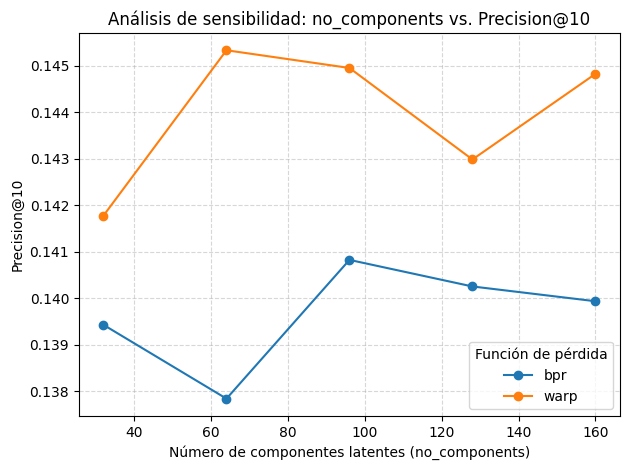

In [ ]:
def plot_sensitivity(results_df, K=10):
    fig, ax = plt.subplots()
    # Recorremos cada tipo de loss y trazamos su curva
    for loss_type, subset in results_df.groupby('loss'):
        ax.plot(
            subset['no_components'],
            subset['precision'],
            marker='o',
            label=loss_type
        )

    ax.set_xlabel('Número de componentes latentes (no_components)')
    ax.set_ylabel(f'Precision@{K}')
    ax.set_title('Análisis de sensibilidad: no_components vs. Precision@{}'.format(K))
    ax.legend(title='Función de pérdida')
    ax.grid(True, linestyle='--', alpha=0.5)
    fig.tight_layout()
    plt.show()


plot_sensitivity(df_sensitivity, K=10)
